# Introduction to Alan

Alan is a probabilistic programming language that aims to provide a simple and intuitive way to perform fast Bayesian inference. In particular it is designed to showcase the "Massively Parallel" framework as outline in [[Massively Parallel Reweighted Wake-Sleep]](https://arxiv.org/abs/2305.11022). This introduction assumes some prior familiarity with Bayesian inference and in particular variational Bayesian methods, for those who are not familiar with these [[Variational Inference: A Review for Statisticians]](https://arxiv.org/abs/1601.00670) gives a good overview.

In this introduction we will cover the following topics:

# Outline
* [Introduction](#Introduction-to-Alan)
* [Setup](#Setup)
* [Background](#Background)
    * [Variational Inference](#Variational-Inference)
    * [Importance Sampling](#Importance-Sampling)
        * [Massively Parallel Importance Sampling](#Massively-Parallel-Importance-Sampling)
    * [Reweighted Wake-Sleep](#Reweighted-Wake-Sleep)
    * [Plated Models](#Plated-Models)
        * [MovieLens](#MovieLens)



# Setup

Lets get our imports out of the way first.

In [12]:
import torch as t
import torch.nn as nn
import alan

import matplotlib.pyplot as plt

alan.seed_torch(0)

# Background

In the Bayesian inference framework we reason about unknown quantities, for instance the parameters of a model, by specifying a model that describes how the data was generated. We then use Bayes rule to compute the posterior distribution over the unknown quantities given the data.

In general this is intractable and so we must resort to approximations. Probabilistic programming languages provide a convenient way to specify a model and then perform inference on it. Using Alan you can specity a prior $p(\theta)$, a likelihood $p(x|\theta)$ as follows:


In [13]:
def P(tr):
    '''
    Bayesian Gaussian Model
    '''
    a = t.zeros(5)
    tr('mu', alan.Normal(a, t.ones(5)))
    tr('obs', alan.MultivariateNormal(tr['mu'], t.eye(5)))

We can then sample some synthetic data from this generative model:

In [14]:
data = alan.Model(P).sample_prior(varnames=('obs',))


Then we can perform inference in the following ways: 

1. approximate the posterior $p(\theta|x)$ using a variational approximation $q_\phi(\theta)$
2. sample from the posterior $p(\theta|x)$
3. compute importance weighted moment estimates of the posterior $p(\theta|x)$

Lets look first at variational inference.


## Variational Inference

Variational inference is a method for approximating the posterior distribution $p(\theta|x)$ by finding the member of a family of distributions $q_\phi(\theta)$ that is closest to the posterior in terms of the KL divergence between them.

Our approximate posterior is a member of a family of distributions $q_\phi(\theta)$ parameterised by $\phi$. We can then write the KL divergence between the approximate posterior and the true posterior as:
$$
\begin{align}
\phi^* &= \arg\min_\phi \text{KL}(q_\phi(\theta)||p(\theta|x)) \\
&= \arg\min_\phi \mathbb{E}_{q_\phi(\theta)}\left[\log q_\phi(\theta) - \log p(\theta|x)\right] \\
&= \arg\min_\phi \mathbb{E}_{q_\phi(\theta)}\left[\log q_\phi(\theta) - \log p(x|\theta) - \log p(\theta)\right] \\
\end{align}
$$

In Alan we can define a variational distribution by specifying the type of distribution we want to use and the parameters of that distribution as follows:


In [15]:
class Q(alan.AlanModule):
    def __init__(self):
        super().__init__()
        self.m_mu = nn.Parameter(t.zeros(5,))
        self.log_s_mu = nn.Parameter(t.zeros(5,))

    def forward(self, tr):
        tr('mu', alan.Normal(self.m_mu, self.log_s_mu.exp()))

and then we can define an Alan "model" conditioned on the synthetic data from above:

In [16]:
cond_model = alan.Model(P, Q()).condition(data=data)

We can find the optimal parameters of the variational distribution by minimising the KL divergence between the variational distribution and the posterior using gradient descent. In Alan we do this as follows:

In [24]:
opt = t.optim.Adam(cond_model.parameters(), lr=1e-3)

K=1
print("K={}".format(K))
for i in range(2000):
    opt.zero_grad()
    elbo = cond_model.sample_perm(K, True).elbo()
    (-elbo).backward()
    opt.step()

    if 0 == i%200:
        print(elbo.item())

K=1
-7.331614152356114
-7.018507921119259
-7.369998824582947
-7.439181310228523
-7.420816972518029
-7.2609127240957605
-7.42427314894479
-7.286349303982281
-7.29899514643861
-7.237515069290502


## Importance Sampling

Above you will notice that we define $K=1$. In Alan we use importance weighted estimates of the log marginal likelihood to calculate our objects and other terms of interest. This means that we draw samples from our approximate posterior and then weight them by the ratio of the posterior and the variational distribution. We can write the evidence lower bound (ELBO) in the single sample setting as follows:

$$
\begin{align}
\log p(x) &= \log \mathbb{E}_{q_\phi(\theta)}\left[\frac{p(x, \theta)}{q_\phi(\theta)}\right] \\
&\geq \mathbb{E}_{q_\phi(\theta)}\left[ \log \frac{p(x, \theta)}{q_\phi(\theta)}\right] \\
&= \mathbb{E}_{q_\phi(\theta)}\left[ \log \mathcal{P} \right]
\end{align}
$$

Where $\log \mathcal{P} = \log \frac{p(x, \theta)}{q_\phi(\theta)}$ is an unbiased estimate of the log marginal likelihood (when samples are drawn from $q_\phi(\theta)$). We can then recover a number of methods of interest by making difference choices of $\mathcal{P}$. For instance, we can recover the [[Importance weighted autoencoder]](https://arxiv.org/pdf/1509.00519.pdf) lower bound by taking multiple importance samples to obtain a better estimate of the log marginal likelihood like so:

$$
\begin{align}
\log p(x) &\geq \mathbb{E}_{\theta_k \sim q_\phi(\theta)}\left[ \log \frac{1}{K}\sum_{k=1}^K \frac{p(x, \theta_k)}{q_\phi(\theta_k)} \right] \\
&= \mathbb{E}_{q_\phi(\theta)}\left[ \log \mathcal{P_{\text{IW}}} \right] \\
\end{align}
$$

We can perform VI using importance weighted estimates of the log marginal likelihood as follows:

In [18]:
# Inference using K=5 samples from the approximate posterior
opt = t.optim.Adam(cond_model.parameters(), lr=1e-3)

K=5
print("K={}".format(K))
for i in range(2000):
    opt.zero_grad()
    elbo = cond_model.sample_global(K, True).elbo()
    (-elbo).backward()
    opt.step()

    if 0 == i%200:
        print(elbo.item())

K=5


AttributeError: module 'alan.traces' has no attribute 'TraceQGlobal'

``model.sample_global`` is the function alan uses to do "regular" importance sampling as described above. But the real point of Alan is to use the "Massively Parallel" framework to perform importance sampling in a more efficient way.

### Massively Parallel Importance Sampling

If we instead draw $K$ samples of each latent variable ($n$) Alan, and its massively parallel estimates of the log marginal likelihood, can be used to reason about all $K^n$ combinations of samples. To ease thinking about this, we denote the collection of K samples for latent $i$ as 

$$ 
z_i = \{z_{i}^1, z_{i}^2, \dots, z_{i}^K\} \in \mathcal{Z}_i^K
$$

We sample these from IID distributions over the samples:

$$
Q_\text{MP}(z|x) = \prod_{i=1}^n Q_\text{MP}(z_i|z_j \text{ for all } j \in \text{qa}(i))
$$

where $\text{qa}(i)$ denotes the parents of $z_i$ in the approximate posterior. We can choose how to construct $Q_\text{MP}$, each choice being a different way of mixing across parent particles. More details can be found in appendix B of [[Massively Parallel Reweighted Wake-Sleep]](https://arxiv.org/abs/2305.11022).

This construction should result in tighter evidence lower bounds in VI and better estimates of the posterior in sampling. In Alan we can perform massively parallel importance sampling VI as follows:

In [22]:
# Inference using K=10 samples from the approximate posterior
opt = t.optim.Adam(cond_model.parameters(), lr=1e-3)

K=10
print("K={}".format(K))
for i in range(2000):
    opt.zero_grad()
    ## Corresponds to permuting parent particles:
    elbo = cond_model.sample_perm(K, True).elbo() 
    (-elbo).backward()
    opt.step()

    if 0 == i%200:
        print(elbo.item())

K=10
-7.357962184521081
-7.322980667965933
-7.354314514434495
-7.35736023585982
-7.341047118544817
-7.306613158307386
-7.382165646203613
-7.335521611281054
-7.2797140135494764
-7.325921657734655


## (Massively Parallel) Reweighted Wake-Sleep

[[Reweighted wake-sleep]](https://arxiv.org/abs/1406.2751) is a method for training generative models that uses importance sampling to estimate the gradient of the log marginal likelihood with respect to the parameters of the model. It is a generalisation of [[wake-sleep]](https://www.mitpressjournals.org/doi/abs/10.1162/neco.1995.7.3.445) that allows us to use any variational distribution and any generative model. In particular, since reparaterisation is not required, it can be used with discrete latent variables.

Unlike variational inference, reweighted wake-sleep doesn't have a unified objective. Instead it updates the parameters of the generative model and the approximate posterior with two different updates. In an ideal world where we had access to the true posterior we would perform:

$$
\begin{align}
  \Delta \theta_\text{post} &= \mathbb{E}_{P_\theta(z^k| x)}[\nabla_\theta \log P_\theta(z, x)]\\
  \Delta \phi_\text{post} &= \mathbb{E}_{P_\theta(z^k| x)}[\nabla_\phi   \log Q_\phi(z| x)]
\end{align}
$$

The update for the parameters of P is the M-step in EM, and the update for the parameters of Q is maximum likelihood using samples from the true posterior.

Since we don't have access to the true posterior we can sample from the approximate posterior and perform importance weighting. Noting that both of these updates are expectations under the approximate posterior we can write them in the form $\Delta_\text{post} = \mathbb{E}_{P_\theta(z^k| x)}[\Delta(z^k)]$ and thus we get:

$$
\begin{align}
\Delta_\text{post} = \mathbb{E}_{Q_\phi(z^k| x)}\left[\frac{P_\theta(z^k| x)}{Q_\phi(z^k| x)}\Delta(z^k)\right]
\end{align}
$$

But since $P_\theta(z^k| x) = \frac{P_\theta(z^k, x)}{P_\theta(x)}$, and we can't usually compute $P_\theta(x)$, we can instead use the unbiased importance weighting estimate of $P_\theta(x)$ from earlier:

$$
\begin{align}
\Delta_\text{post} = \mathbb{E}_{Q_\phi(z^k| x)}\left[\frac{\frac{P_\theta(z^k, x)}{Q_\phi(z^k| x)}}{P_\text{IW}}\Delta(z^k)\right]
\end{align}
$$

And with a bit more tricky algebra we could also use the massively parallel importance sampling estimate of the log marginal likelihood:

$$
\begin{align}
\Delta_\text{post} = \mathbb{E}_{Q_\phi(z^k| x)}\left[\frac{\frac{P_\theta(z^k, x)}{\prod_i Q(z_i^{k_i}| x, z_{\text{qa}(i)})}}{P_\text{MP}}\Delta(z^k)\right]
\end{align}
$$

To perform Massive Parallel Reweighted Wake-Sleep in Alan we can do the following:

In [27]:
opt = t.optim.Adam(cond_model.parameters(), lr=1e-3)

K=10
print("K={}".format(K))
for i in range(1000):
    opt.zero_grad()
    p_obj, q_obj = cond_model.sample_perm(K, True).rws()
    (-q_obj).backward()
    opt.step()

    if 0 == i%100:
        print(cond_model.sample_perm(K, True).elbo().item())

K=10
-13.737521921894437
-14.36128585683559
-14.50401148667989
-16.00966385066256
-17.01409246004574
-16.122603701194627
-17.207089166951572
-17.21516695641802
-18.54146940972209
-17.72110144197151


# Plated Models

Now that we have a basic idea of how Alan works, lets try making our models more complex. In particular, lets try to model some data that has a heirarchical structure. 

## MovieLens

The [[MovieLens-100k dataset]](https://grouplens.org/datasets/movielens/100k/) consists of 100,000 movie ratings from 1000 users on 1700 movies. Each film, indexed $j$ has a vector of genre tags $x_j$. We observe user ratings $y_{mj}$ for each user $m$ and film $j$ and binarise them according to ${0,1,2,3} \rightarrow 0$ and ${4,5} \rightarrow 1$ to get $\mathrm{Rating}_{mj}$.

We can model this data using a hierarchical bayesian model as so:

$$
\begin{align}
\nonumber
\boldsymbol{\mu} &\sim \mathcal{N}(\mathbf{0}_{18},1) \\
\nonumber
\psi &\sim \operatorname{Categorical}([0.1,0.5,0.4,0.05,0.05]) \\
\nonumber
\mathbf{z}_m &\sim \mathcal{N}(\boldsymbol{\mu},\exp(\psi) \mathbf{I}), \ m=1,\dotsc,M \\
\mathrm{Rating}_{mj} &\sim \operatorname{Bernoulli}(\sigma(\mathbf{z}_m^\intercal \mathbf{x}_j)), \ j=1,\dotsc,\mathrm{N}
\end{align}
$$

Lets write this in Alan. Note that Alan deals with plates passing a plate name to ``tr`` in the generative model ``P``, and by requiring the user to name parameters that are plate dependent in the approximate posterior ``Q``. A dictionary of plate sizes must be passed to the sampling functions as we will see later.

In [38]:
M=450
N=20

sizes = {'Users':M, 'Films':N}
d_z = 18
def P(tr, x):
    '''
    Heirarchical Model
    '''
    tr('mu_z', alan.Normal(tr.zeros((d_z,)), tr.ones((d_z,))))
    tr('psi_z', alan.Categorical(t.tensor([0.1,0.5,0.4,0.05,0.05])))
    tr('z', alan.Normal(tr['mu_z'], tr['psi_z'].exp()), plates='Users')
    tr('obs', alan.Bernoulli(logits = tr['z'] @ x))


class Q(alan.AlanModule):
    def __init__(self):
        super().__init__()
        #mu_z
        self.m_mu_z = nn.Parameter(t.zeros((d_z,)))
        self.log_mu_z_sigma = nn.Parameter(t.zeros((d_z,)))
        #psi_z
        self.m_psi_z = nn.Parameter(t.randn((5,)))
        #z
        self.mu = nn.Parameter(t.zeros((M,d_z), names=('Users',None)))
        self.log_z_sigma = nn.Parameter(t.zeros((M,d_z), names=('Users',None)))


    def forward(self, tr, x):
        tr('mu_z', alan.Normal(self.m_mu_z, self.log_mu_z_sigma.exp()))
        tr('psi_z', alan.Categorical(logits=self.m_psi_z))

        tr('z', alan.Normal(self.mu, self.log_z_sigma.exp()))

Now we get our data, the data must be appropriately named according to the plate names in the model:

In [40]:
covariates = {'x':t.load('movielens_data/weights_{0}_{1}.pt'.format(N, M))}
test_covariates = {'x':t.load('movielens_data/test_weights_{0}_{1}.pt'.format(N, M))}
all_covariates = {'x': t.cat([covariates['x'],test_covariates['x']],-2).rename('Users','Films',...)}
covariates['x'] = covariates['x'].rename('Users','Films',...)
test_covariates['x'] = test_covariates['x'].rename('Users','Films',...)


data = {'obs':t.load('movielens_data/data_y_{0}_{1}.pt'.format(N, M))}
test_data = {'obs':t.load('movielens_data/test_data_y_{0}_{1}.pt'.format(N, M))}
all_data = {'obs': t.cat([data['obs'],test_data['obs']], -1).rename('Users','Films')}
data['obs'] = data['obs'].rename('Users','Films')
test_data['obs'] = test_data['obs'].rename('Users','Films')

Now we can run inference:

In [41]:
elbos = []
pred_lls = []

K=10

q = Q()
cond_model = alan.Model(P, q).condition(data=data)
opt = t.optim.Adam(cond_model.parameters(), lr=1e-3)
for i in range(500):
    opt.zero_grad()
    sample = cond_model.sample_same(K, reparam=False, inputs=covariates)


    elbo = sample.elbo()
    elbos.append(elbo.item())
    
    p_obj, q_obj = sample.rws()
    (-q_obj).backward()

    opt.step()



    sample = cond_model.sample_same(K, reparam=False, inputs=covariates)
    pred_lls.append(cond_model.predictive_ll(sample, N = 10, inputs_all=all_covariates, data_all=all_data)['obs'])


    if i % 100 == 0:
        print(f'Elbo: {elbos[-1]}, Pred_ll: {pred_lls[-1]}')')        

Elbo: -6329.243725695521
Elbo: -16869.199723156613
Elbo: -9524.176957885558
Elbo: -9471.521307200137
Elbo: -16562.111421852165


And lets look at the results:

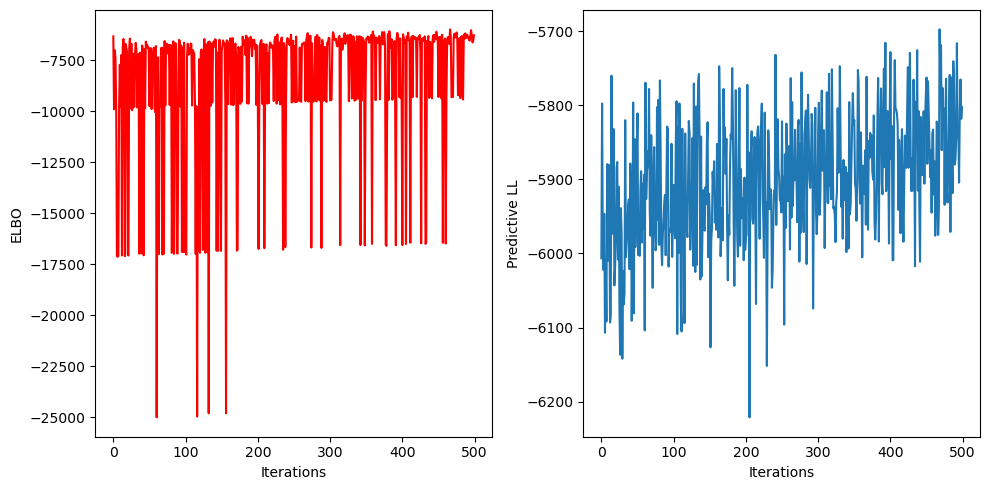

In [44]:
#plotting elbos and predictive lls in a single figure

fig, ax = plt.subplots(1,2, figsize=(10,5))
ax[0].plot(elbos, c='red')
ax[0].set_xlabel('Iterations')
ax[0].set_ylabel('ELBO')

ax[1].plot(pred_lls)
ax[1].set_xlabel('Iterations')
ax[1].set_ylabel('Predictive LL')

plt.tight_layout()
plt.show()


# MP Importance Weighted Moment Estimates

We can also use Alan to compute importance weighted moment estimates of the posterior. This is useful for computing things like the posterior mean and variance and can be used directly in a Bayesian workflow or for the initialisation of MCMC or a variational posterior for instance. We can do this as follows:

# Tips for getting good performance